In [1]:
import ee
from random import randint
from ee import batch
from IPython.display import Image
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
ee.Initialize()

In [3]:
roi_app1 = ee.FeatureCollection('ft:1d80zsjZAW6wudXeTBOxg-akjEauImi3nzO504Kty')
roi_app3 = ee.FeatureCollection('ft:1bL0bRT1upfY52UZY4FqHUlM9HVfARH2buL3sVvxS')
VB = ee.Image('users/gcarrasco/VB')
ML_1 = ee.Image('users/gcarrasco/ML_1')
ML_2 = ee.Image('users/gcarrasco/ML_2')
ML_3 = ee.Image('users/gcarrasco/ML_3')
SL = ee.Image('users/gcarrasco/SL')
UM = ee.Image('users/gcarrasco/UM')
LI = ee.Image('users/gcarrasco/LI')
collection_rgb = ee.ImageCollection([VB,ML_1,ML_2,ML_3,SL,UM,LI])
collection_m = ee.ImageCollection('users/edgarmanrique30/comunities')
geometry = ee.FeatureCollection('ft:1O-lP3K4Po6HV2MNvLwPheszU_lnGihdKCxaBbuuT')
geometry = geometry.geometry()

In [4]:
def __maskvaluesmulti__(img):
	mask = img.neq(0)
	return img.mask(mask)
def __maskvaluesrgb__(img):
	mask = img.neq(255)
	return img.mask(mask)
def addndvi(img):
	ndvi = img.expression('(NIR-RED)/(NIR+RED)', {
		'NIR': img.select('NIR'),
		'RED': img.select('red_m')
		}).rename('NDVI')
	return img.addBands(ndvi)
def __clip_col__(img): return img.clip(geometry)
def __renameBandsRGB__ (img):return img.rename(['red','green','blue','mask'])
def __renameBandsMulti__(img):return img.rename(['red_m','green_m','Edge Red','NIR'])

In [5]:
#masking values
collection_rgb = collection_rgb.map(__maskvaluesrgb__)
collection_m = collection_m.map(__maskvaluesmulti__)
#clipping extent
collection_rgb = collection_rgb.map(__clip_col__)
collection_m = collection_m.map(__clip_col__)
#renaming bands
collection_rgb = collection_rgb.map(__renameBandsRGB__)
collection_m = collection_m.map(__renameBandsMulti__)
#converting collection to single images
collection_rgb = collection_rgb.median()
collection_m = collection_m.median()
#getting a new image with all the bands
image = collection_rgb.select(['red', 'green', 'blue']).addBands(collection_m, ['red_m','green_m','Edge Red','NIR'])
image = addndvi(image)
#training samples for sequoia images
polygons= ee.FeatureCollection(roi_app1,"geometry")
polygons_app3 = ee.FeatureCollection(roi_app3,"geometry")
classifier = ee.Classifier.randomForest(20)
#specifying bands to use 
bands = ['red', 'green', 'blue', 'red_m','green_m','Edge Red','NIR']

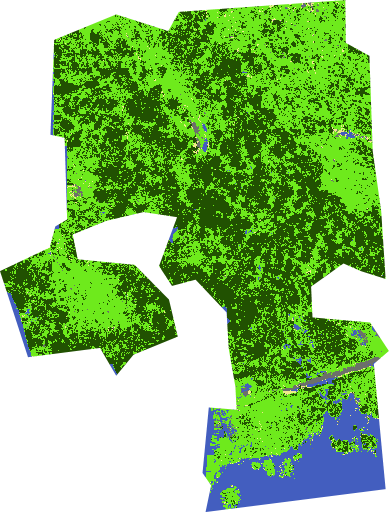

In [6]:
seed = 2000
polygons1 = polygons.randomColumn('random',seed);
regionsOfInterest1 = image.select(bands).sampleRegions(polygons1,['class', 'random'],2)
fullClassifier1 = classifier.train(regionsOfInterest1, 'class', bands)
image_app1 = image.classify(fullClassifier1)
image_class1= image_app1.visualize(**{'min':0, 'max':4, 'palette':'EEEA88,6eea1c,215101,435ebf,6c706a'}) 
url = image_class1.getThumbUrl({'region':geometry.geometries().get(0).getInfo()})
Image(url=url, embed=True, format='png')

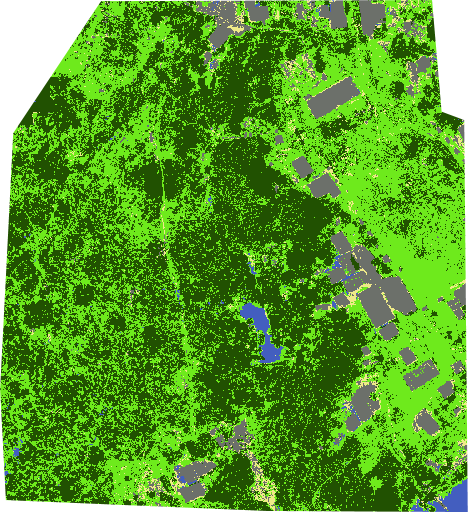

In [7]:
image_class1= image_app1.visualize(**{'min':0, 'max':4, 'palette':'EEEA88,6eea1c,215101,435ebf,6c706a'}) 
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

In [8]:
mancioLima = ee.Geometry(geometry.geometries().get(4))
salvador = ee.Geometry(geometry.geometries().get(2))
urcoMirano = ee.Geometry(geometry.geometries().get(0)).union(ee.Geometry(geometry.geometries().get(5))).union(ee.Geometry(geometry.geometries().get(7)))
libertad = ee.Geometry(geometry.geometries().get(3)).union(ee.Geometry(geometry.geometries().get(6)))
vistoBueno = ee.Geometry(geometry.geometries().get(1))

In [9]:
communities = ee.List([mancioLima, salvador, urcoMirano, libertad, vistoBueno])

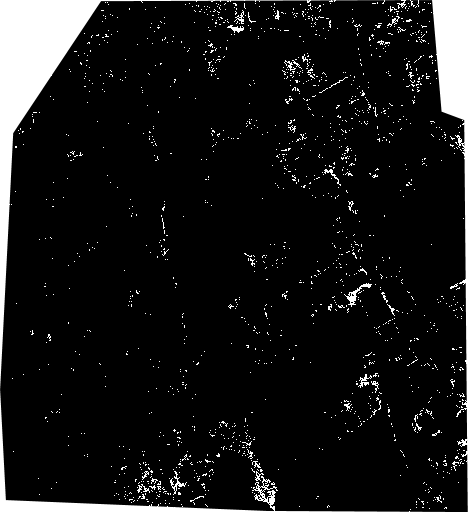

In [10]:
image_class1= image_app1.eq(0)
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

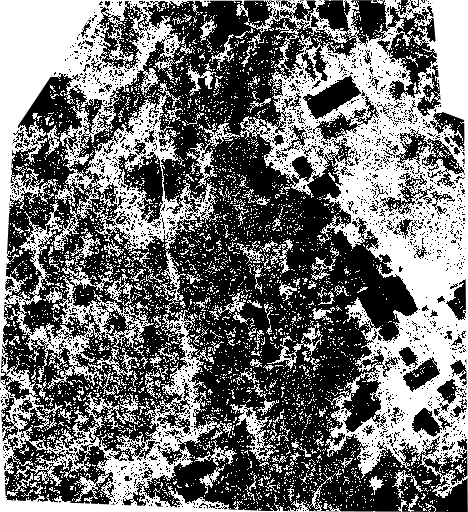

In [11]:
image_class1= image_app1.eq(1)
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

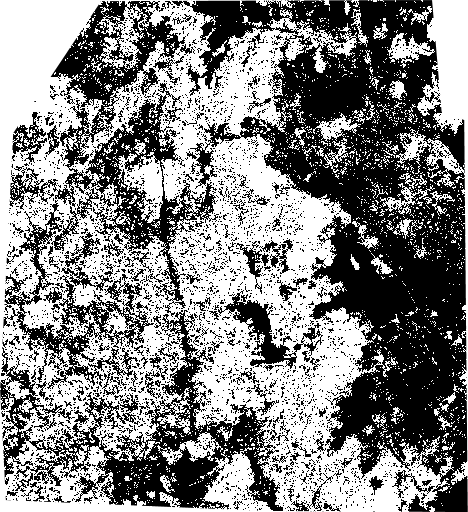

In [12]:
image_class1= image_app1.eq(2)
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

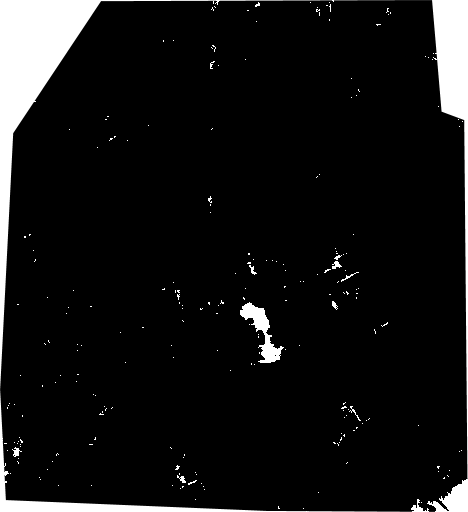

In [13]:
image_class1= image_app1.eq(3)
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

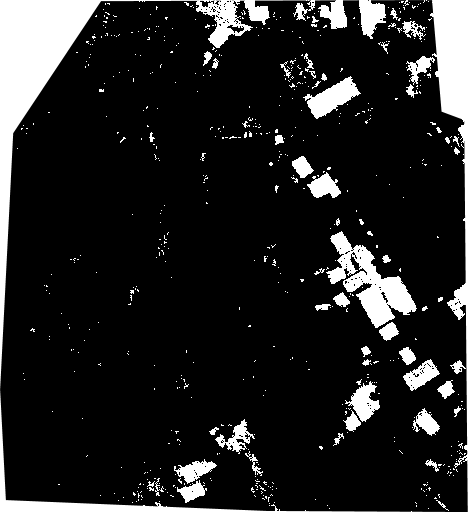

In [14]:
image_class1= image_app1.eq(4)
url = image_class1.getThumbUrl({'region':geometry.geometries().get(7).getInfo()})
Image(url=url, embed=True, format='png')

In [15]:
def get_count(image, clase, geometry):
    count = image.eq(clase).gt(0).reduceRegion(reducer = ee.Reducer.sum(), geometry = geometry, scale = 0.02, bestEffort = True)
    return count.toArray().getInfo()

In [16]:
salvador = {}
clase = 0
while clase < 5:
    print clase
    key = clase
    value = get_count(image_app1, clase, communities.get(1))
    salvador[key] = np.mean(value)
    clase += 1
df_salvador = pd.DataFrame(salvador.items(), columns = ['class', 'count'])
print df_salvador

salvador_prop = pd.DataFrame(index = range(5), columns = ['Salvador'])
i = 0
while i < 5:
    salvador_prop['Salvador'][i]=df_salvador['count'][i]/df_salvador['count'].sum()
    i += 1
print salvador_prop

0
1
2
3
4
   class         count
0      0  6.160009e+05
1      1  5.121983e+06
2      2  1.850913e+06
3      3  1.957894e+06
4      4  4.450460e+05
    Salvador
0  0.0616504
1   0.512617
2   0.185243
3   0.195949
4   0.044541


In [17]:
libertad = {}
clase = 0
while clase < 5:
    print clase
    key = clase
    value = get_count(image_app1, clase, communities.get(3))
    libertad[key] = np.mean(value)
    clase += 1
df_libertad = pd.DataFrame(libertad.items(), columns = ['class', 'count'])
print df_libertad

libertad_prop = pd.DataFrame(index = range(5), columns = ['Libertad'])
i = 0
while i < 5:
    libertad_prop['Libertad'][i]=df_libertad['count'][i]/df_libertad['count'].sum()
    i += 1
print libertad_prop


0
1
2
3
4
   class         count
0      0  4.265152e+05
1      1  2.491080e+06
2      2  3.431038e+06
3      3  3.338303e+06
4      4  3.070154e+05
    Libertad
0  0.0426773
1   0.249259
2   0.343311
3   0.334032
4  0.0307201


In [18]:
urcoMirano = {}
clase = 0
while clase < 5:
    print clase
    key = clase
    value = get_count(image_app1, clase, communities.get(2))
    urcoMirano[key] = np.mean(value)
    clase += 1
df_urcoMirano = pd.DataFrame(urcoMirano.items(), columns = ['class', 'count'])
print df_urcoMirano

urcoMirano_prop = pd.DataFrame(index = range(5), columns = ['UrcoMirano'])
i = 0
while i < 5:
    urcoMirano_prop['UrcoMirano'][i]=df_urcoMirano['count'][i]/df_urcoMirano['count'].sum()
    i += 1
print urcoMirano_prop

0
1
2
3
4
   class         count
0      0  1.904066e+05
1      1  3.833961e+06
2      2  5.110642e+06
3      3  3.636324e+05
4      4  5.014034e+05
  UrcoMirano
0  0.0190406
1   0.383394
2   0.511062
3  0.0363631
4  0.0501401


In [19]:
vistoBueno = {}
clase = 0
while clase < 5:
    print clase
    key = clase
    value = get_count(image_app1, clase, communities.get(4))
    vistoBueno[key] = np.mean(value)
    clase += 1
df_vistoBueno = pd.DataFrame(vistoBueno.items(), columns = ['class', 'count'])
print df_vistoBueno

vistoBueno_prop = pd.DataFrame(index = range(5), columns = ['VistoBueno'])
i = 0
while i < 5:
    vistoBueno_prop['VistoBueno'][i]=df_vistoBueno['count'][i]/df_vistoBueno['count'].sum()
    i += 1
print vistoBueno_prop

0
1
2
3
4
   class         count
0      0  4.719193e+05
1      1  3.509957e+06
2      2  5.017060e+06
3      3  5.475367e+05
4      4  4.535337e+05
  VistoBueno
0  0.0471919
1   0.350995
2   0.501706
3  0.0547536
4  0.0453533


In [24]:
df_communities = pd.concat([vistoBueno_prop, libertad_prop], axis=1)
df_communities = pd.concat([df_communities, salvador_prop], axis=1)
df_communities = pd.concat([df_communities, urcoMirano_prop], axis=1)
df_communities['class'] = ['Bare soil','Low vegetation','High vegetation','Water','Urban']
df_communities

,VistoBueno,Libertad,Salvador,UrcoMirano,class
0,0.0471919,0.0426773,0.0616504,0.0190406,Bare soil
1,0.350995,0.249259,0.512617,0.383394,Low vegetation
2,0.501706,0.343311,0.185243,0.511062,High vegetation
3,0.0547536,0.334032,0.195949,0.0363631,Water
4,0.0453533,0.0307201,0.044541,0.0501401,Urban


In [25]:
df_long = pd.melt(df_communities, id_vars=['class'], var_name='communities')
df_long

,class,communities,value
0,Bare soil,VistoBueno,0.0471919
1,Low vegetation,VistoBueno,0.350995
2,High vegetation,VistoBueno,0.501706
3,Water,VistoBueno,0.0547536
4,Urban,VistoBueno,0.0453533
5,Bare soil,Libertad,0.0426773
6,Low vegetation,Libertad,0.249259
7,High vegetation,Libertad,0.343311
8,Water,Libertad,0.334032
9,Urban,Libertad,0.0307201


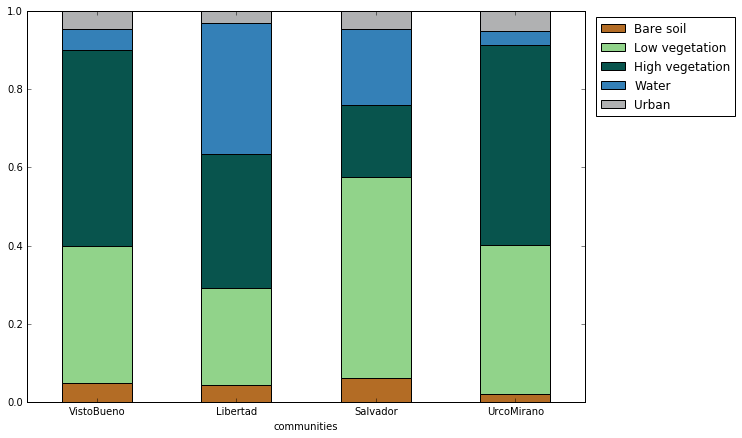

In [26]:
fig, ax = plt.subplots(figsize=(10,7))  

classes = df_long['class'].drop_duplicates()
margin_bottom = np.zeros(len(df_long['communities'].drop_duplicates()))
colors = ['#B36C25', '#91D38A', '#08544D', '#3480B7', '#b0b1b2']

for num, classf in enumerate(classes):
    values = list(df_long[df_long['class'] == classf].loc[:, 'value'])

    df_long[df_long['class'] == classf].plot.bar(x='communities',y='value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=classf)
    margin_bottom += values
plt.legend( loc = 'upper right')
plt.legend(bbox_to_anchor=(1.28, 1.0))
plt.xticks(rotation=0)
plt.show()
